In [75]:
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
from numpy import zeros, column_stack
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_post_beer_attributes.csv")
df

,id,attribute,count
0,203,coffee,1
1,203,conditioned,1
2,203,imperial,1
3,203,imperial milk stout,1
4,203,milk,1
...,...,...,...
997,264,ale,1
998,264,hoppy ale,1
999,265,hoppy,1
1000,265,ale,1


In [61]:
vectors = []
attributes = sorted(set(df["attribute"]))

for attribute in attributes:
    tokens = attribute.lower().split(" ")
    if len(tokens) == 1:
        vectors.append(nlp(tokens[0]).vector)
    else:
        v = nlp(tokens[0]).vector
        for t in tokens[1:]:
            if t != "&":
                v = v + nlp(t).vector
        vectors.append(v)

In [62]:
len(vectors)

221

---

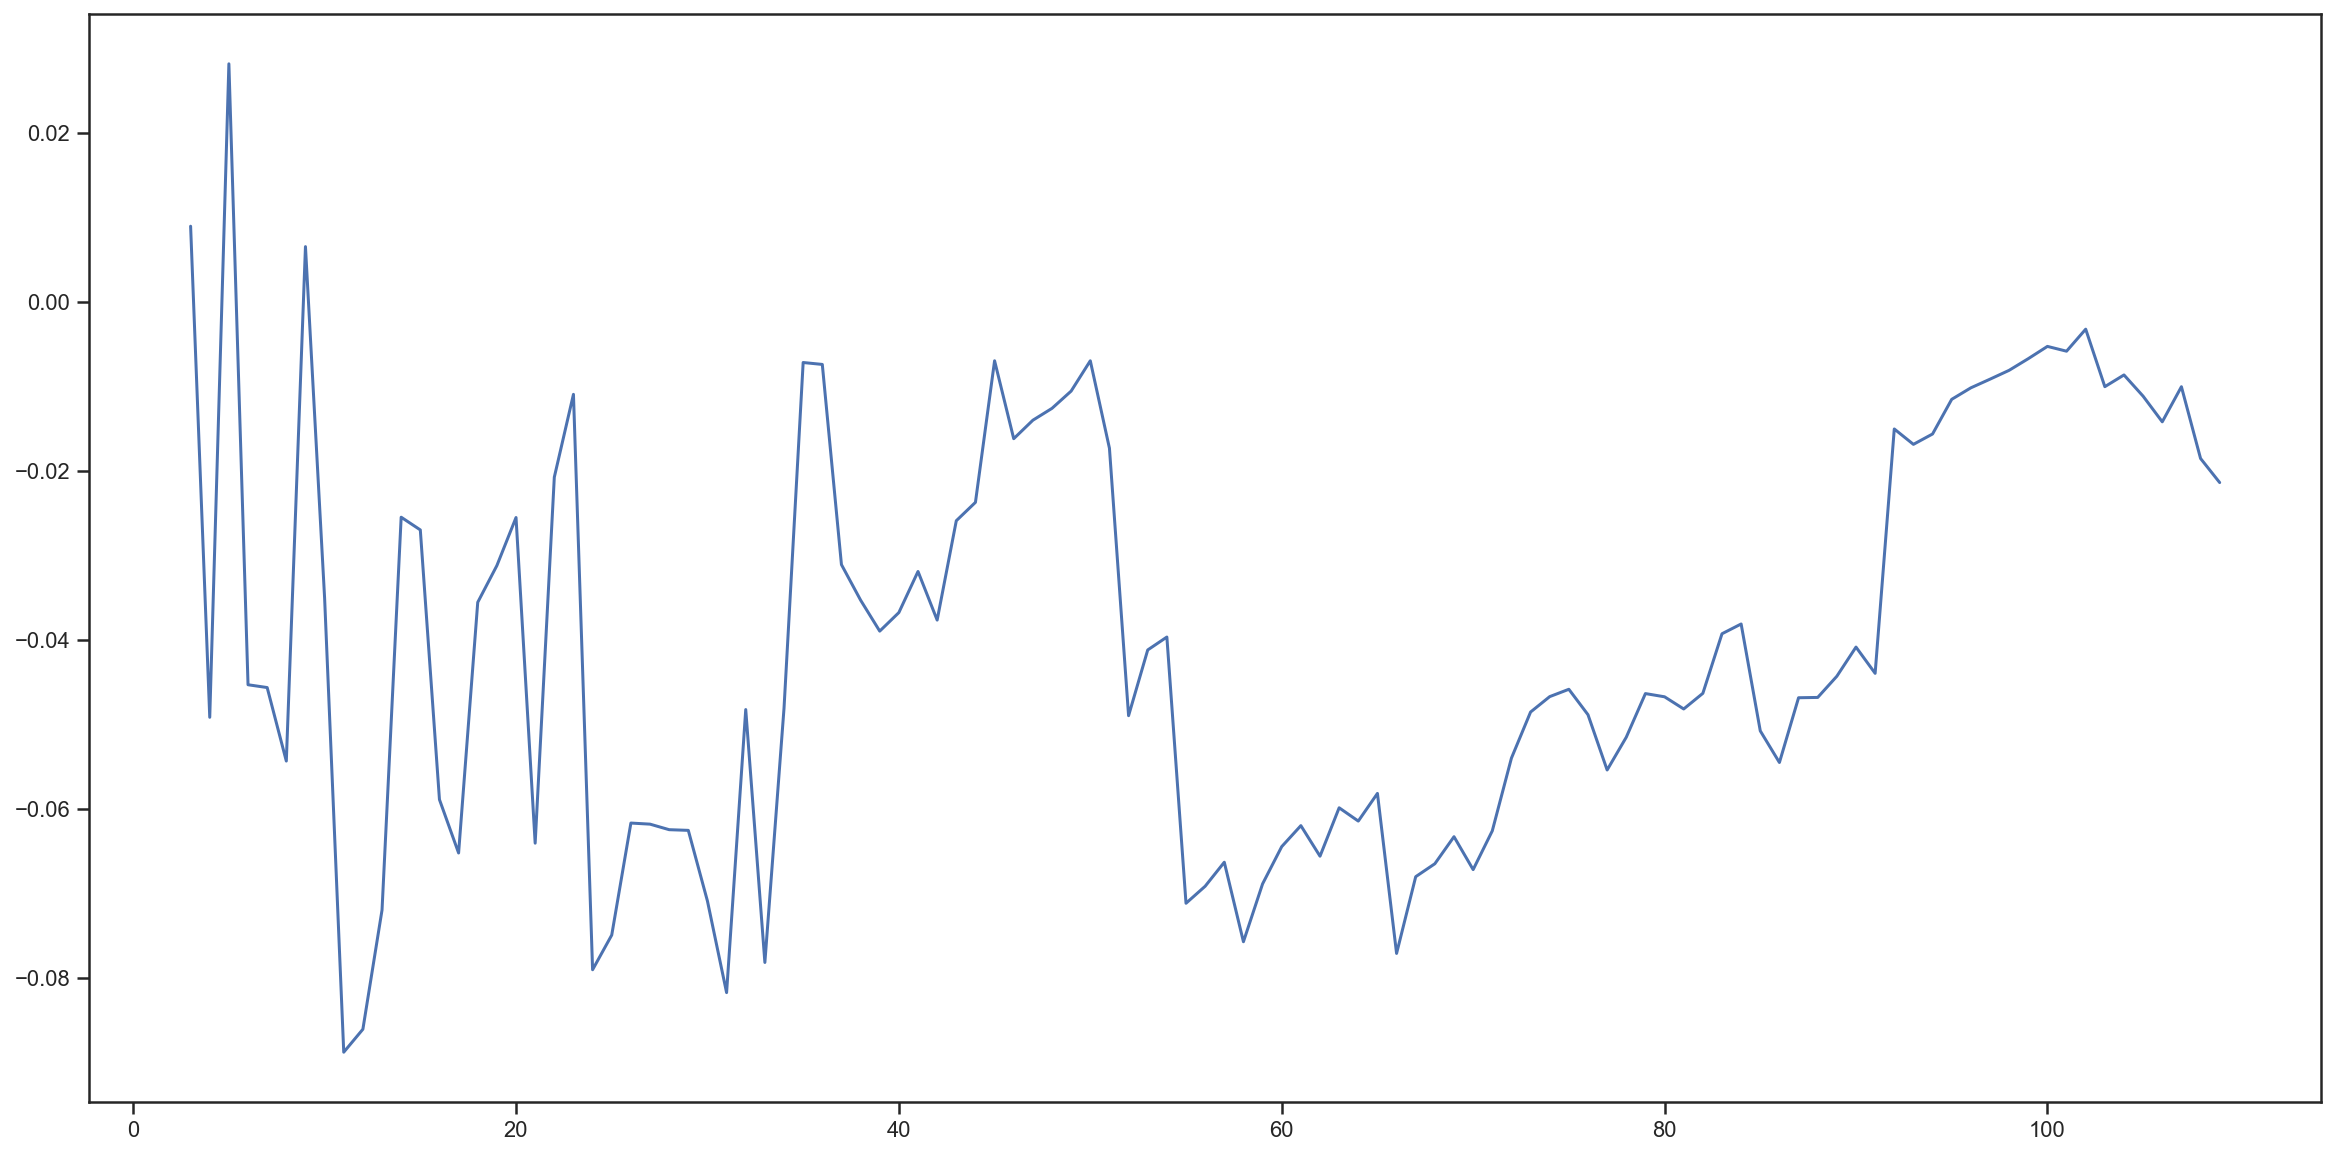

In [63]:
cluster_sizes = []
silhouettes = []

for i in range(3, len(vectors) // 2):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024).fit(vectors)
    silhouettes.append(silhouette_score(vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [64]:
cluster_sizes[silhouettes.index(max(silhouettes))]

5

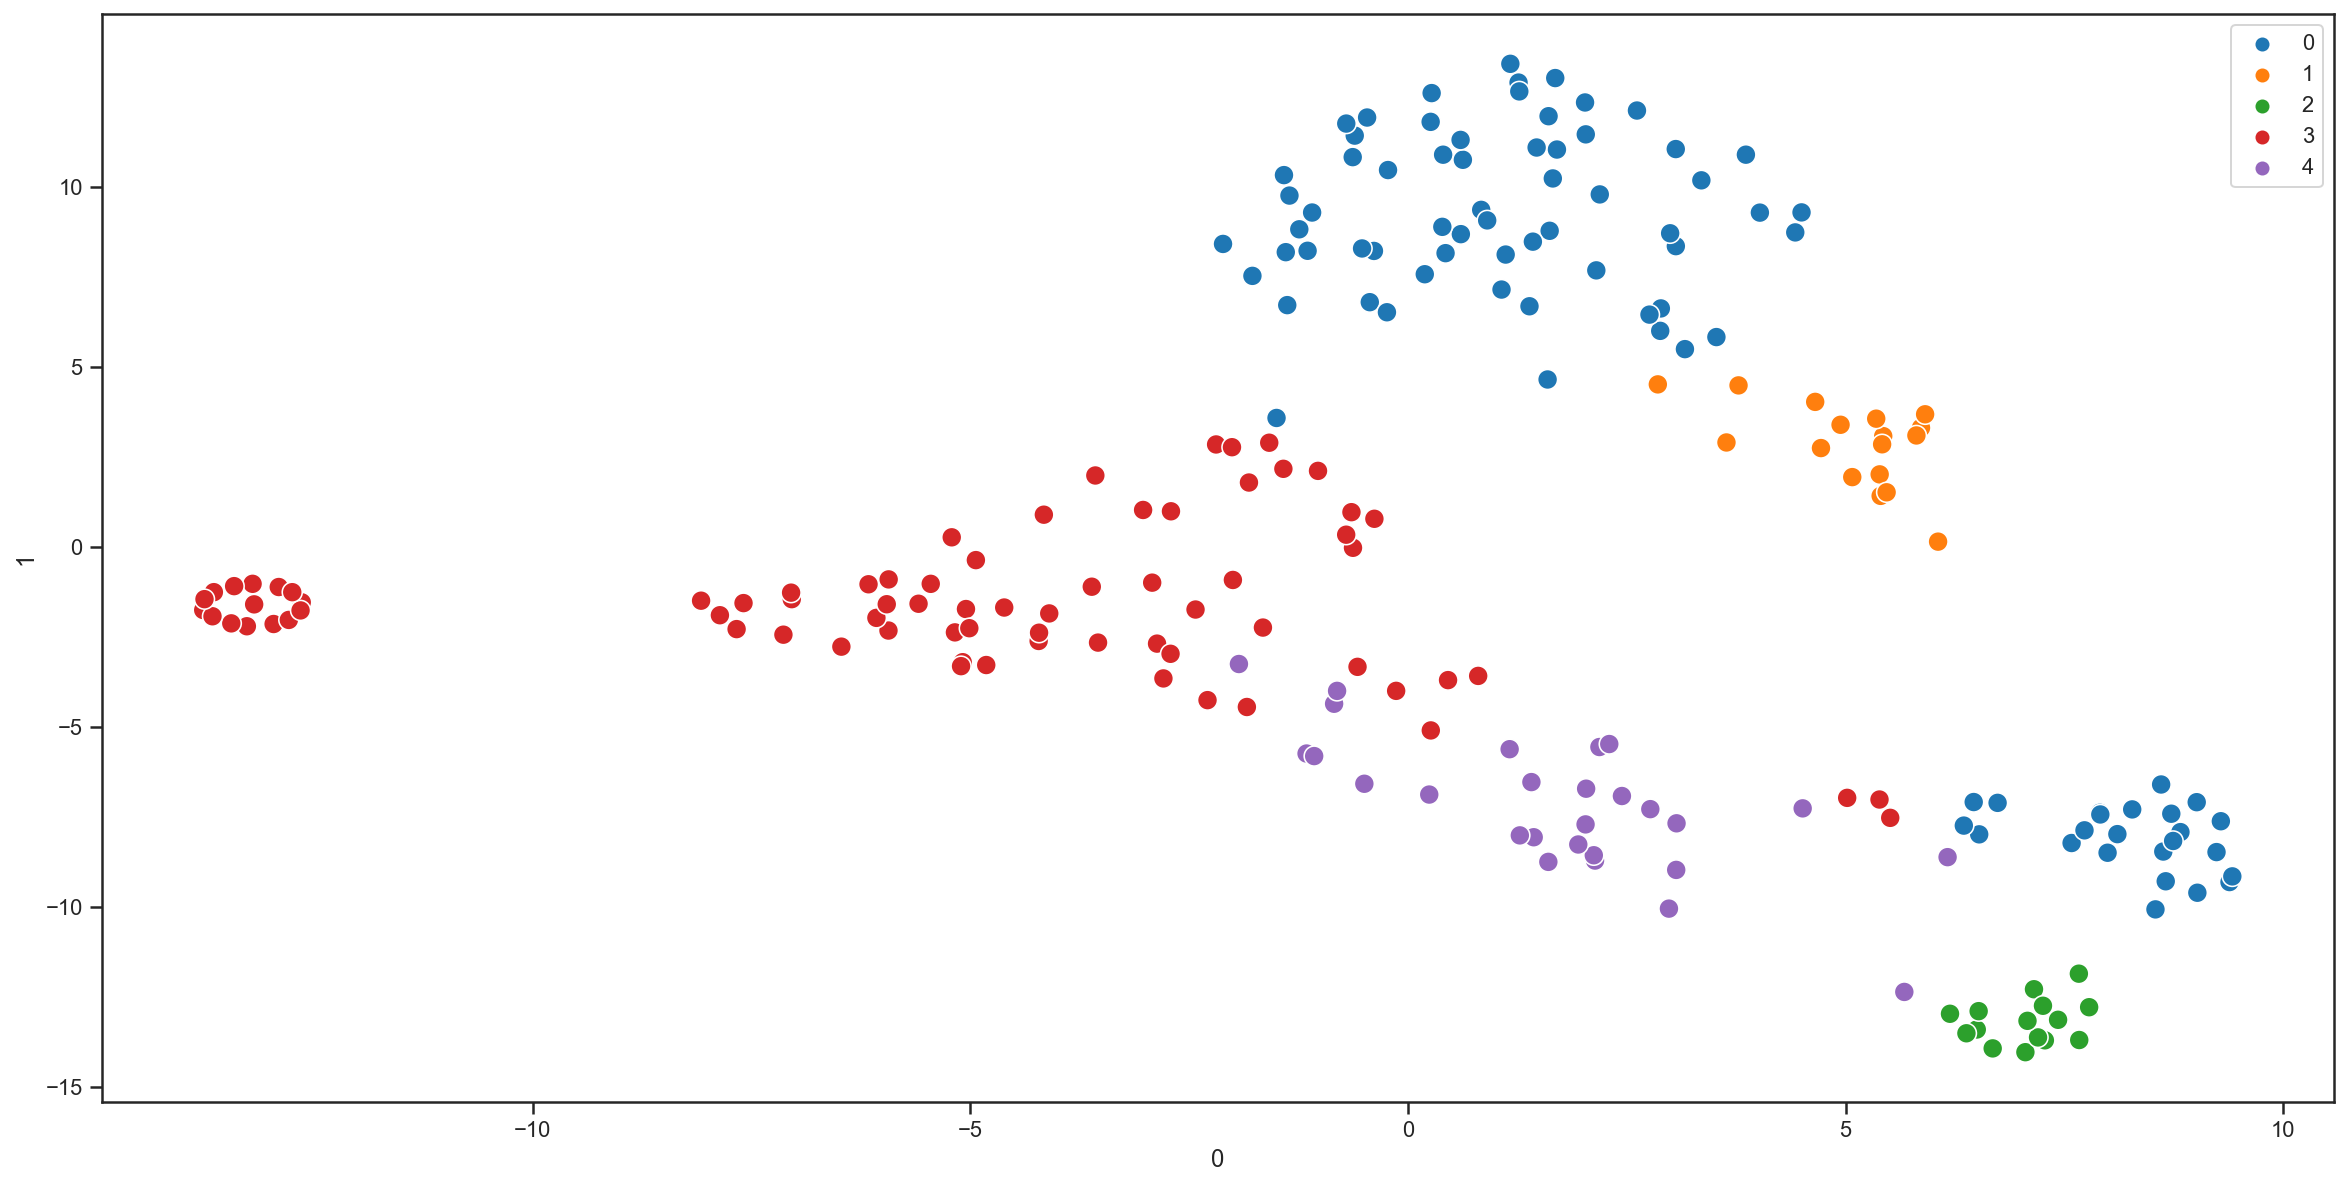

In [66]:
kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], random_state=1024).fit(vectors)

tsne = TSNE(n_components=2, random_state=1024, metric="cosine")
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [67]:
sorted(list(zip(attributes, kmeans.labels_)), key=lambda x : x[1])

[('banana', 0),
 ('beans', 0),
 ('black walnut', 0),
 ('blueberry', 0),
 ('boiled', 0),
 ('boiled overnight', 0),
 ('butter', 0),
 ('butterscotch candies', 0),
 ('cacao', 0),
 ('cacao nibs', 0),
 ('caramel', 0),
 ('chamomile', 0),
 ('cherry', 0),
 ('chocolate', 0),
 ('cinnamon', 0),
 ('coconut', 0),
 ('coffee', 0),
 ('corn', 0),
 ('creamed', 0),
 ('creamy', 0),
 ('dessert', 0),
 ('figs', 0),
 ('fresh', 0),
 ('fruit', 0),
 ('fruit juice', 0),
 ('fruit juice concentrate', 0),
 ('ginger', 0),
 ('granola', 0),
 ('grapefruit', 0),
 ('guatemalan coffee', 0),
 ('guava', 0),
 ('hibiscus', 0),
 ('honey', 0),
 ('hot peppers', 0),
 ('juice', 0),
 ('kettle soured', 0),
 ('key lime', 0),
 ('lemon', 0),
 ('lime', 0),
 ('madagascar vanilla', 0),
 ('mango', 0),
 ('maple', 0),
 ('maple granola', 0),
 ('maple syrup', 0),
 ('marshmallow', 0),
 ('marshmallows', 0),
 ('melon', 0),
 ('milk', 0),
 ('molasses', 0),
 ('nectarines', 0),
 ('oats', 0),
 ('orange', 0),
 ('palm kernel oil', 0),
 ('palo santo wood',

---

In [69]:
attribute_vectors = dict(zip(attributes, vectors))
beer_ids = sorted(set(df["id"]))
beer_vectors = []

for beer_id in beer_ids:
    vector = zeros(300)
    for (i, row) in df[df["id"] == beer_id].iterrows():
        for j in range(0, row["count"]):
            vector = vector + attribute_vectors[row["attribute"]]
    beer_vectors.append(vector)

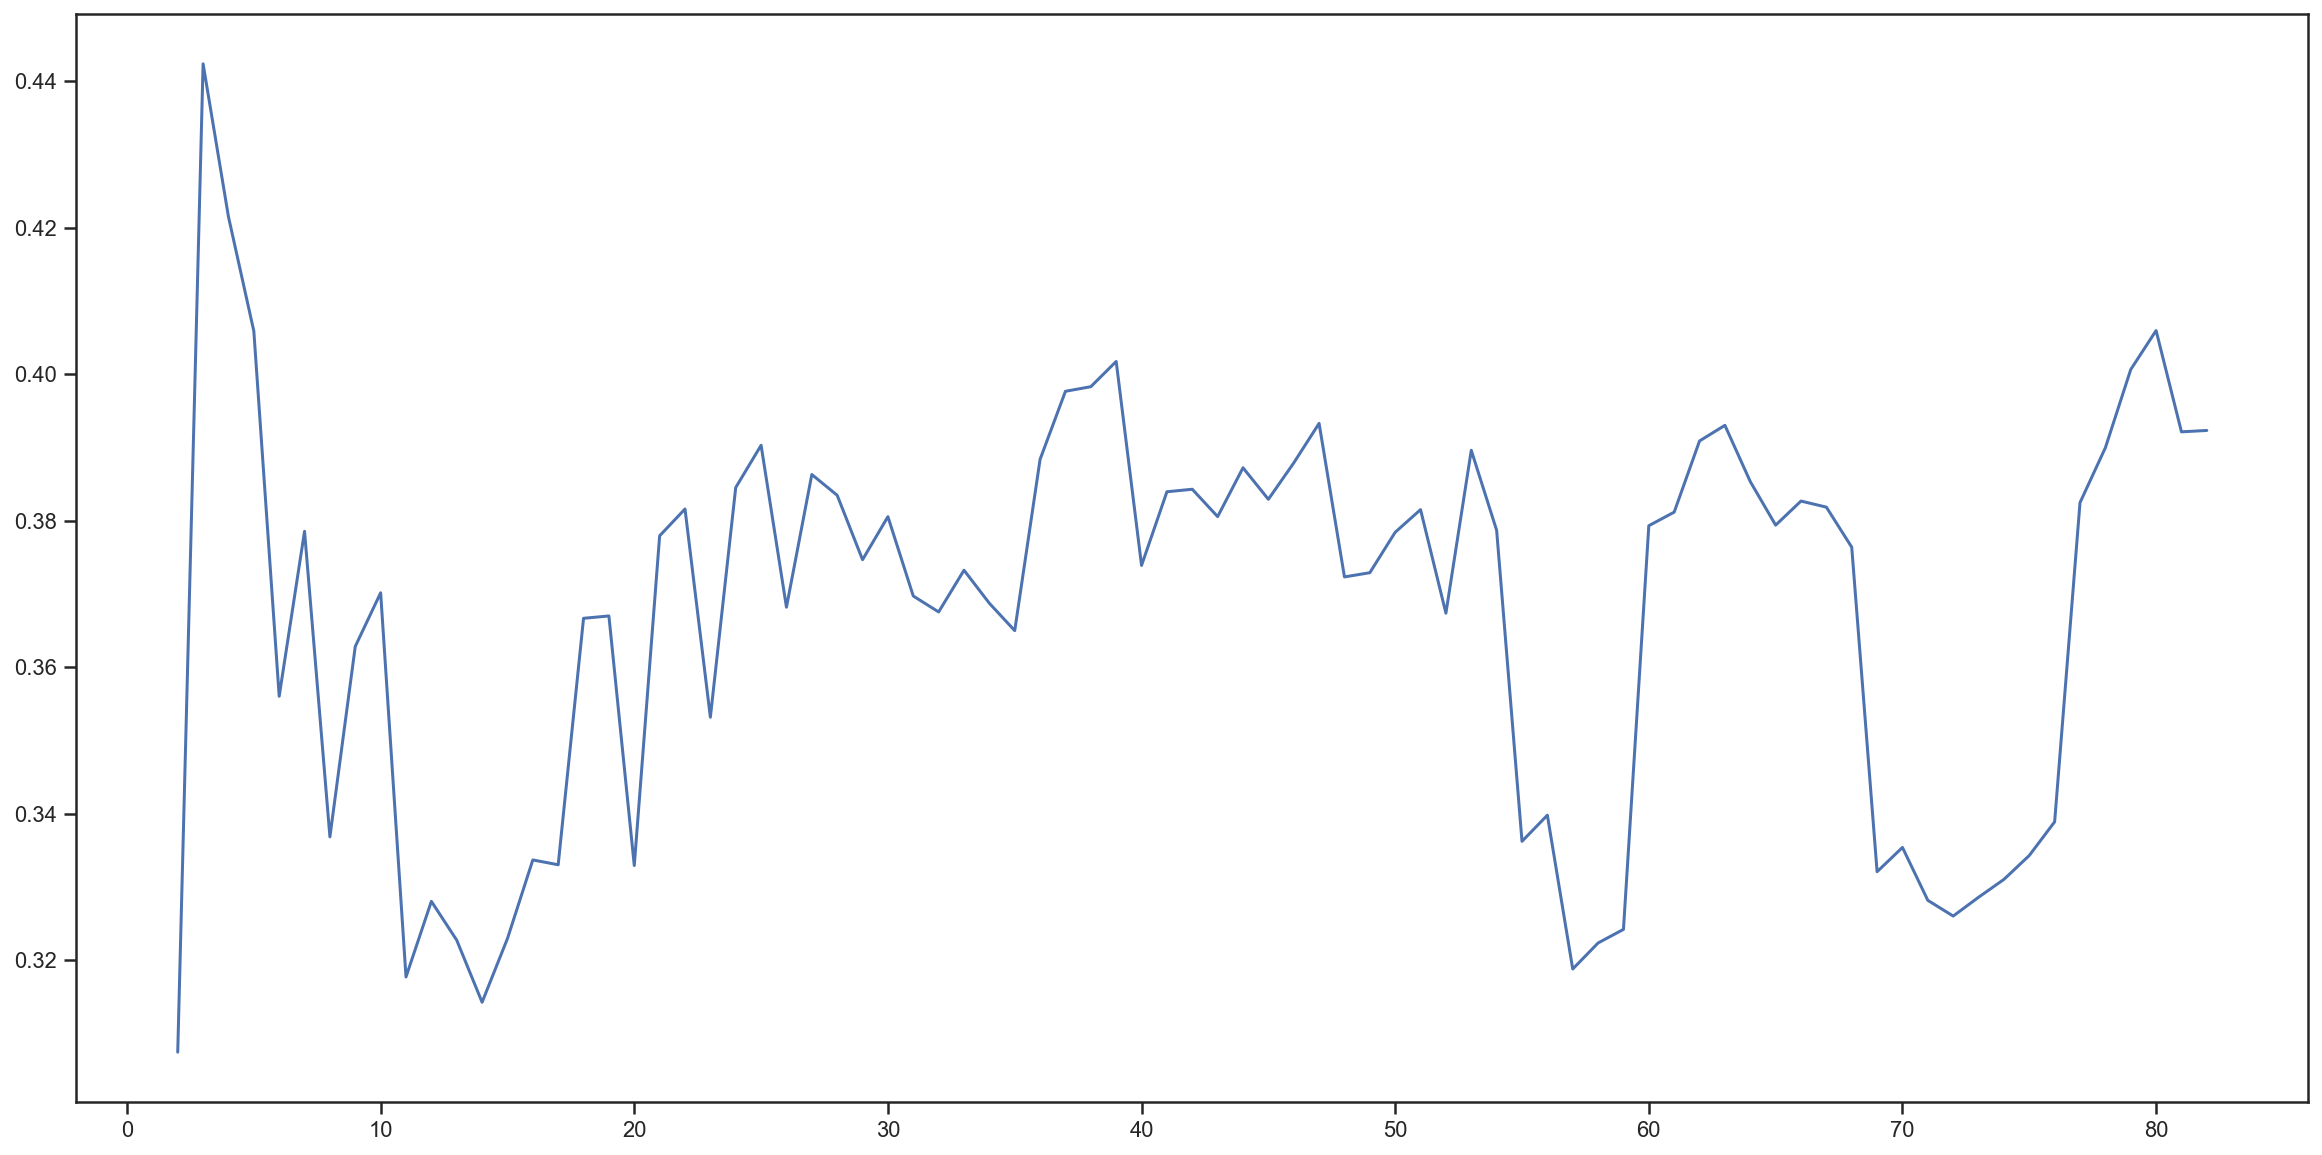

In [70]:
cluster_sizes = []
silhouettes = []

for i in range(2, len(beer_vectors) // 2):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024).fit(beer_vectors)
    silhouettes.append(silhouette_score(beer_vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [71]:
cluster_sizes[silhouettes.index(max(silhouettes))]

3

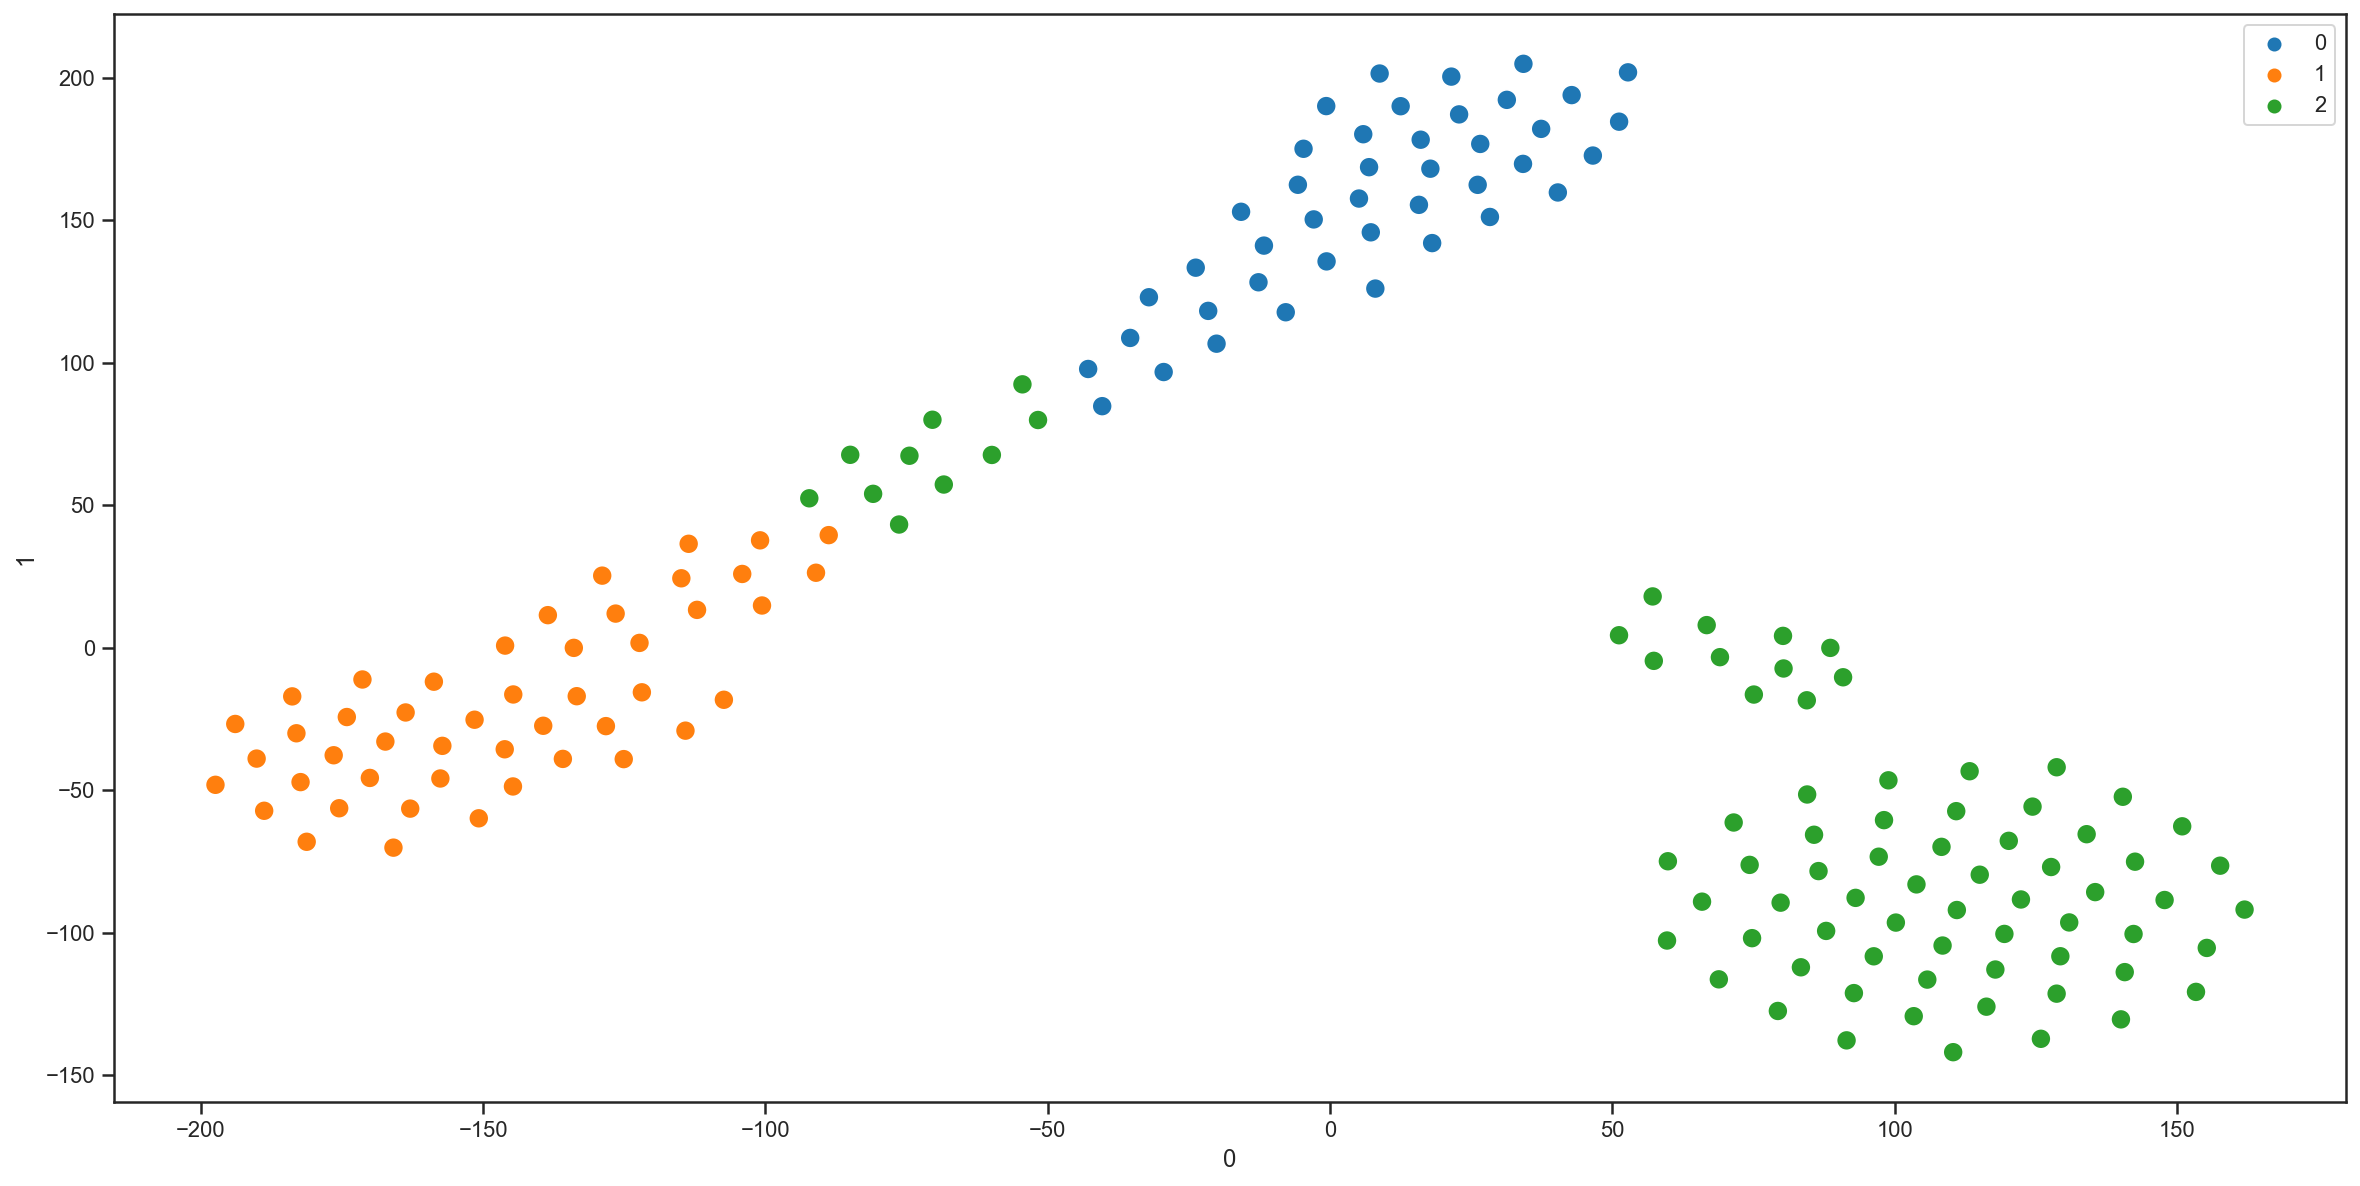

In [93]:
kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], 
                random_state=1024).fit(beer_vectors)

tsne = TSNE(n_components=2, random_state=1024, metric="cosine", learning_rate=1000)
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(beer_vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [94]:
cluster_attributes = {l : [] for l in set(kmeans.labels_)}
reduced["id"] = beer_ids
reduced["cluster_id"] = kmeans.labels_

for (i, row) in reduced.iterrows():
    attributes = list(df[df["id"] == row["id"]]["attribute"])
    cluster_attributes[row["cluster_id"]] += attributes

appearing_in_all = None
for cluster_id in cluster_attributes:
    if appearing_in_all is None:
        appearing_in_all = set(cluster_attributes[cluster_id])
    else:
        appearing_in_all = appearing_in_all.intersection(set(cluster_attributes[cluster_id]))
        
print(appearing_in_all)
    
{c : sorted(Counter([a for a in cluster_attributes[c] if a not in appearing_in_all]).items(), 
            key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{'refermented', 'honey', 'lactose', 'soured', 'conditioned', 'fruit', 'fermented', 'ale', 'stout', 'hopped', 'kettle soured', 'yeast', 'hoppy', 'dry hopped'}


{0: [('ipa', 9),
  ('lupulin', 6),
  ('powder', 6),
  ('session', 5),
  ('simcoe', 4),
  ('mosaic', 4),
  ('citra', 4),
  ('@rojosroastery', 3),
  ('enigma', 3),
  ('galaxy', 3),
  ('american', 2),
  ('oats', 2),
  ('azacca', 2),
  ('session ipa', 2),
  ('vic secret', 2),
  ('amarillo', 2),
  ('coffee', 2),
  ('keller', 2),
  ('wheat', 2),
  ('pineapple', 2),
  ('triple', 2),
  ('triple ipa', 2),
  ('dipa', 2),
  ('smoothie', 2),
  ('medusa', 2),
  ('@thereferendbierblendery', 1),
  ('american blonde', 1),
  ('blonde', 1),
  ('motueka', 1),
  ('grist', 1),
  ('organic', 1),
  ('el dorado', 1),
  ('carrion', 1),
  ('collaboration', 1),
  ('american varietals', 1),
  ('fresh', 1),
  ('cacao', 1),
  ('cacao nibs', 1),
  ('ochochoque', 1),
  ('pastrywine', 1),
  ('quilla', 1),
  ('kölsch', 1),
  ('palo santo wood', 1),
  ('dryhopped', 1),
  ('hoped', 1),
  ('nelson', 1),
  ('nelson sauvin', 1),
  ('sauvin', 1),
  ('pellets', 1),
  ('nectarines', 1),
  ('peaches', 1),
  ('russell', 1),
  ('

In [95]:
cluster_names = {0 : "IPAs", 1 : "Stouts and Sours", 2 : "Hoppy Ales"}

In [96]:
reduced["cluster_name"] = reduced["cluster_id"].apply(lambda x : cluster_names[x])

In [99]:
reduced["attributes"] = reduced["id"].apply(lambda x : ", ".join(sorted(df[df["id"] == x]["attribute"])))
reduced

,0,1,id,cluster_id,cluster_name,attributes
0,110.920082,-57.285957,0,2,Hoppy Ales,"ale, hoppy, hoppy ale"
1,150.942307,-62.599495,1,2,Hoppy Ales,"ale, hoppy, hoppy ale"
2,74.330322,-76.125946,2,2,Hoppy Ales,"ale, hoppy, hoppy ale"
3,75.075523,-16.379524,3,2,Hoppy Ales,"ale, honey, hoppy, hoppy ale"
4,57.355427,-4.555933,6,2,Hoppy Ales,"ale, hoppy, hoppy ale, lactose, peach, referme..."
...,...,...,...,...,...,...
162,140.765427,-113.746689,261,2,Hoppy Ales,"ale, hoppy, hoppy ale"
163,84.516510,-51.434158,262,2,Hoppy Ales,"ale, hoppy, hoppy ale"
164,-125.089157,-39.027435,263,1,Stouts and Sours,"ale, fruit, kettle soured, kettle soured ale, ..."
165,85.735771,-65.560867,264,2,Hoppy Ales,"ale, hoppy, hoppy ale"


In [100]:
reduced.to_csv("troon_TSNE_kmeans_clusters.csv", index=False)